# Case #3. Fracking results predictions

![](https://assets.nrdc.org/sites/default/files/styles/ec_home_alert_large/public/fracking_cross_section_v9.png?itok=40YGp5Qz)

source: https://www.nrdc.org/stories/fracking-101

**Fracking (ГРП)** - the hydraulic fracturing method consists in creating a highly conductive crack in the target reservoir

Solves the following tasks:
* Improved well productivity/pick-up rate
* Increased oil recovery rate
* Reduction of working depression while maintaining the debit

![](https://stimul.online/upload/medialibrary/940/9404384d18a1137993a665684582caff.jpg)
source: https://stimul.online/articles/interview/skvazhiny-zhdut-intellekta/

## Problem set: 

Currently, the selection process for wells candidates for fracking relies on the manual approach when the experience of the particular person can be the most important factor. Two different experts can come up with different conclusions. The goal is to create an automated well selection process that can be used an expert to predict successfulness of secondary fracking.


**Fracking success criteria:**
1. Instant increase in the flow rate of at least 15 tons per day
2. Average increase in the flow rate of at least 10 tons per day within next 6 month

## Available data

Training dataset was collected from the results of fracking performed on the field M until 2017 and consist of 1094 records. Features were selected after consultations with the fracking experts. For the sake of convinience feature names were encoded with lating letter.

```python
                    {"A": "Нефтенасыщенная толщина",
                    "B": "Темп падения дебита жидкости за 6 месяцев",
                    "C": "Темп падения дебита жидкости за 12 месяцев",
                    "D": "Отношение текущего дебита жидкости к максимальному",
                    "E": "Расчлененность пласта",
                    "F": "Накопленная добыча жидкости на 1 метр ННТ",
                    "G": "Дебит жидкости скважин окружения на 1 метр ННТ",
                    "H": "Проницаемость пласта",
                    "I": "Отношение дебита жидкости скважины к ННТ",
                    "J": "Отношение накопленной добычи жидкости скважин окружения на к ННТ",
                    "K": "Расстояние до ближайшей скважины с успешным ГРП",
                    "L": "Расстояние до ближайшей скважины с неуспешным ГРП",
                    "M": "Расстояние до ближайшей нагнетательной скважины",
                    "N": "Количество скважин с успешным ГРП в радиусе 1 километра",
                    "O": "Количество скважин с неуспешным ГРП в радиусе 1 километра",
                    "P": "Обводненность до ГРП",
                    "Q": "Накопленная закачка скважин окружения на 1 метр ННТ",
                    "U": "Количество дней после последнего ГТМ",
                    "V": "Количество дней после последнего ГРП",
                    "X": "Накопленная добыча нефти скважин окружения на 1 метр ННТ",
                    "G1": "Забойное давление",
                    "H1": "Пластовое давление"}
```

Testing dataset consists of 1191 records with no labels. Some of these wells were planned for fracking in the future and some of the wells currently under fracking with no result available at the moment

![](../pictures/FrackingDataFlow.png)

In [71]:
%pylab inline 
%load_ext autoreload
%autoreload 2

# external
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style('whitegrid')
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
train = pd.read_csv("../data/FrackingLabeledData.csv")
test = pd.read_csv("../data/FrackingNonLabeledData.csv")

In [73]:
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
            'L', 'M', 'N', 'O', 'P', 'Q', 'U', 'V', 'X', 'G1', 'H1']

## Feature selection

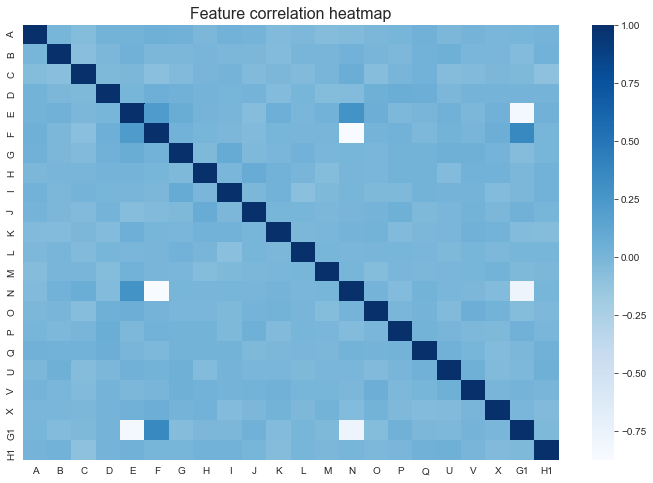

In [74]:
pylab.figure(figsize=(12,8))
pylab.title('Feature correlation heatmap', size=16)
sns.heatmap(train[features].corr(), cmap='Blues')

In [81]:
# took it from here: 
# https://stackoverflow.com/questions/24002820/returning-groups-of-correlated-columns-in-pandas-data-frame

correlation_matrix = train[features].corr().abs()
correlation_matrix.loc[:,:] =  np.tril(correlation_matrix, k=-1)
correlation_matrix = correlation_matrix.stack()
print('Correlation between feature pairs')
correlation_matrix[correlation_matrix > 0.5].sort_values(ascending=False)

Correlation between feature pairs


N   F    0.871926
G1  E    0.831844
    N    0.770783
dtype: float64

### Feature greedy ellimination

In [82]:
from copy import copy
from tqdm import tqdm

def get_correlation_matrix(data: pd.DataFrame, features:list):
    correlation_matrix = data[features].corr().abs()
    correlation_matrix.loc[:,:] =  np.tril(correlation_matrix, k=-1)
    correlation_matrix = correlation_matrix.stack()
    return correlation_matrix[correlation_matrix > 0.8].sort_values(ascending=False)

features_ = copy(features)
for pair in tqdm(get_correlation_matrix(train, features_).to_dict(), desc='greedily eliminating'):
    column_to_remove = train[features].corr().mean()[list(pair)].sort_values().index[1]
    if column_to_remove in features_:
        features_.remove(column_to_remove)
features = features_

greedily eliminating: 100%|██████████| 2/2 [00:00<00:00, 218.32it/s]


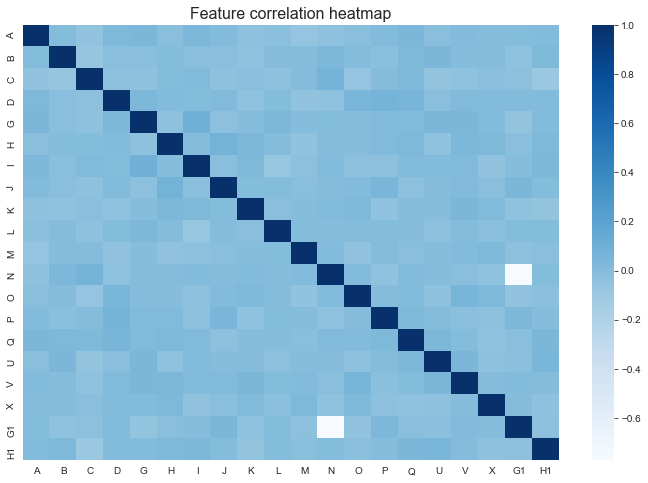

In [83]:
pylab.figure(figsize=(12,8))
pylab.title('Feature correlation heatmap', size=16)
sns.heatmap(train[features].corr(), cmap='Blues')

In [85]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler

class GreedyElimination(TransformerMixin, BaseEstimator):
    """
    Between two pairs of correlated features, I will keep features with lowest mean correlation to all existed features.
    """
    def __init__(self,threshold:float):
        self._threshold = threshold
    
    def fit(self, x:pd.DataFrame, y=None):
        """
        Mandatory method for sklearn.
        """
        return self
    
    @staticmethod
    def get_correlation_matrix(data: pd.DataFrame, features:list, threshold:float):
        """
        Calculate correlated matrix and return the most correlated pairs.
        """
        correlation_matrix = data[features].corr().abs()
        correlation_matrix.loc[:,:] =  np.tril(correlation_matrix, k=-1)
        correlation_matrix = correlation_matrix.stack()
        return correlation_matrix[correlation_matrix > threshold].sort_values(ascending=False)

    def transform(self, x:pd.DataFrame, y=None):
        """
        Mandatory method for sklearn, will delete correlated columns.
        """
        data = x.copy()
        features_ = copy(data.columns.tolist())
        for pair in GreedyElimination.get_correlation_matrix(data, features_, self._threshold).to_dict():
            column_to_remove = data.corr().mean()[list(pair)].sort_values().index[1]
            if column_to_remove in features_:
                features_.remove(column_to_remove)
        return data[features_].values

    

In [138]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


models = [XGBClassifier(),  DecisionTreeClassifier(), LogisticRegression(), SVC()]
results = {}
for model in tqdm(models):
    pipe = (Pipeline([
                ('dealing_with_correlation', GreedyElimination(threshold=0.5)),
                ('scaling', StandardScaler()),
                ('model', model)
             ]))
    
    f_scores = cross_val_score( pipe, 
                                train[features], 
                                train['label'].values, 
                                cv=21, 
                                scoring='f1')
    results[model.__class__.__name__] = f_scores
    
    


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


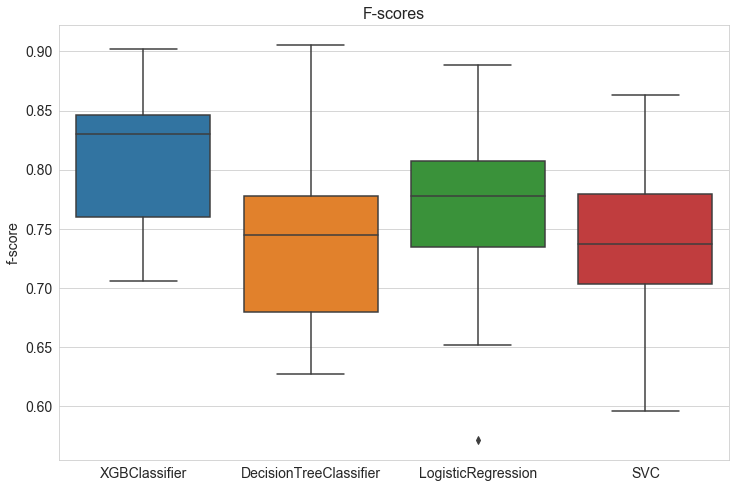

In [158]:
pylab.figure(figsize=(12,8))
pylab.title('F-scores',size=16)
pylab.xticks(size=14)
pylab.yticks(size=14)
pylab.ylabel('f-score', size=14)
sns.boxplot(data=pd.DataFrame(results))

----
# Let's practice

Let's stick with XGBClassifier and will analyze model performace.

* How the confusion matrix looks like?
* Which features are most important for the model?
* How similar labeled dataset (train) with non labeled dataset (test)?
* Can we extend our predictions for unlabeled dataset?

In [159]:
pipeline = (Pipeline([
                ('dealing_with_correlation', GreedyElimination(threshold=0.5)),
                ('scaling', StandardScaler()),
                ('model', XGBClassifier())
             ]))

In [160]:
pipeline.fit(train[features], train['label'])

Pipeline(memory=None,
         steps=[('dealing_with_correlation', GreedyElimination(threshold=None)),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
  

In [162]:
model = pipeline[2]

### Confusion matrix

In [168]:
from sklearn.metrics import confusion_matrix

# confusion_matrix?

### Feature importance


In [174]:
# model.feature_importances_

### Feature similarity between train and test datasets

1. Combine train and test datasets
2. Create new label "is_train" 1 if data from train dataset and 0 if from test dataset. Forget about previous label
3. Shuffle new combined datasets and run cross-validation
4. Check is AUC score is close to 0.5

In [ ]:
# train['is_train'] = 1
# test['is_train'] = 0

# combined_dataset = pd.concat([train, test])


In [178]:
validation_pipeline = (Pipeline([
                            ('scaling', StandardScaler()),
                            ('model', XGBClassifier())
                         ]))

In [177]:
from sklearn.metrics import plot_roc_curve

# plot_roc_curve?